LTOD calculations

Take 3 days worth of gsx input swath data for a sensor
    for each swath locate all measurements that lie between 70 and 71 N (or S) latitude
    save the longitude and UTC for each measurement
    
Plot a histogram of the times - but it's more complicated than that - 
    for each time, which is in UTC, take the longitude and calculate what the ltod is for that
    UTC at that longitude.
    
    i.e. if the UTC is 02:48 and the longitude is -105, then the ltod is ((2*60)+48) + (-105*4)


In [1]:
#from __future__ import print_function
%pylab inline
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import glob as glob
import time
import calendar
import numpy.ma as ma

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
def seconds_to_midnight(seconds):
    """ This function calculates the number of seconds to midnight of the input
        time.  This is used to convert the scan times in the file to local time
        for that day """
    st = time.strptime("01.01.1987", "%d.%m.%Y")
    seconds_to_epoch = calendar.timegm(st)
    # get file epoch date in seconds since 1970
    str_date = time.gmtime(seconds + seconds_to_epoch)
    # get file date from number of seconds since 1987
    dmid = "%02d.%02d.%d" % (str_date.tm_mday, str_date.tm_mon, str_date.tm_year)
    utc_midnight = time.strptime(dmid, "%d.%m.%Y")
    utc_seconds_to_midnight = calendar.timegm(utc_midnight)
    # get midnight of file date in seconds
    return (utc_seconds_to_midnight - seconds_to_epoch)

In [3]:
def create_ltod(files, lat_min=70., lat_max=71.):
    """ This function takes a list of gsx swath files as an argument and
        calculates the local time of each measurement in a specified latitude band
        It returns a 1-D array of the local times (in hours wrt midnight), 
        suitable for creating a histogram """
    
    fid = Dataset(files[0], 'r', 'NETCDF4')
    lat = np.array(fid.variables['latitude_loc1'])
    lon = np.array(fid.variables['longitude_loc1'])
    scantime = np.array(fid.variables['scan_time_loc1'])
    meas = len(fid.dimensions['measurements_loc1'])
    scan_time = np.array([scantime,]*meas).transpose()
    lat_all = lat.flatten()
    lon_all = lon.flatten()
    offset_seconds = seconds_to_midnight(scantime[0]) # get the offset to midnight for the first scanline
    scantime_all = scan_time.flatten() - offset_seconds 
    fid.close()
    for fil in files[1:-1]:
        #print (fil)
        fid = Dataset(fil, 'r', 'NETCDF4')
        scantime = np.array(fid.variables['scan_time_loc1'])
        if (len(scantime)):
            meas = len(fid.dimensions['measurements_loc1'])
            scan_time = np.array([scantime,]*meas).transpose()
            offset_seconds = seconds_to_midnight(scantime[0])
            scantime_all = np.concatenate((scantime_all, (scan_time.flatten() - offset_seconds)))
        else:
            fid.close()
            continue         
        lat = np.array(fid.variables['latitude_loc1'])
        lon = np.array(fid.variables['longitude_loc1'])
        lat_all = np.concatenate((lat_all, lat.flatten()))
        lon_all = np.concatenate((lon_all, lon.flatten()))
        fid.close()
    latm = ma.masked_where((lat_all < lat_min), lat_all)
    lat_band = ma.masked_where( latm > lat_max, latm)
    lon_band = ma.masked_array(lon_all, lat_band.mask)
    scantime_band = ma.masked_array(scantime_all, lat_band.mask)
    final_times = scantime_band + (lon_band*4*60.0)
    ftimes = final_times/3600.
    ftimes[ftimes > 24.0] = ftimes[ftimes > 24.0] - 24.0
    ftimes[ftimes < 0.] = ftimes[ftimes < 0.] + 24.0
    return ftimes

In [4]:
A2_2024 = sort(glob.glob('/scratch/alpine/moha2290/v2_0630_test/AMSR2_GSX/*2024060*.nc'))
len(A2_2024)

130

In [5]:
#ftn_A2_2024 = create_ltod(A2_2024, lat_min = 70.0, lat_max = 71.0)
fts_A2_2024 = create_ltod(A2_2024, lat_max = -70.0, lat_min = -71.0)



/tmp/ipykernel_1940734/2390887965.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lat = np.array(fid.variables['latitude_loc1'])
/tmp/ipykernel_1940734/2390887965.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = np.array(fid.variables['longitude_loc1'])
/tmp/ipykernel_1940734/2390887965.py:10: DeprecationWarning: `np.bool` is a depreca

Text(0.5,1,'AMSR2 South - 1200/2400\n2021 doy 183-191\n127 files')

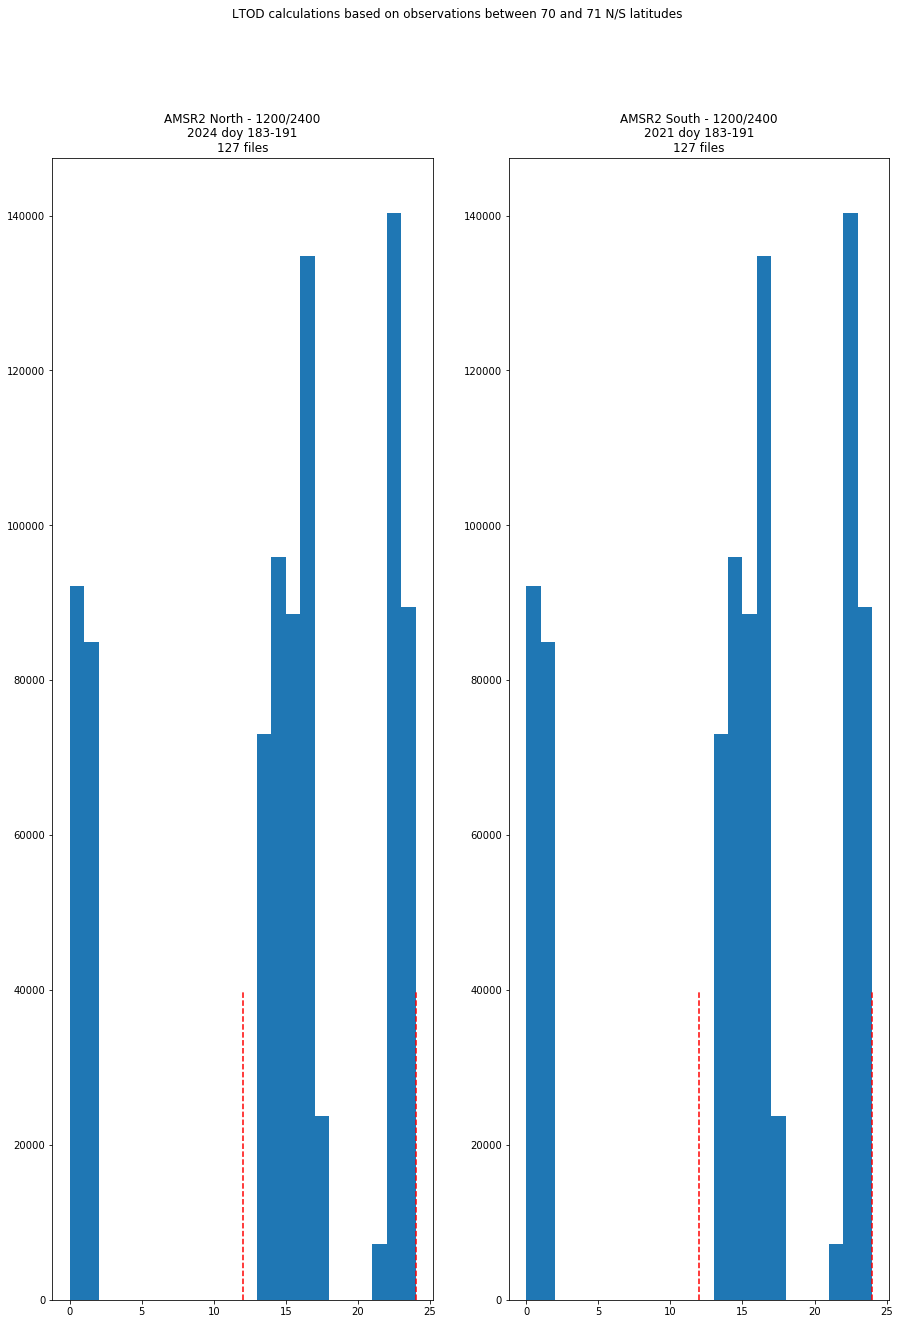

In [6]:
fig = plt.figure(figsize=(15,21))
plt.suptitle('LTOD calculations based on observations between 70 and 71 N/S latitudes')
a = fig.add_subplot(1,2,1)
plt.hist(fts_A2_2024,bins=(np.arange(25)))
plt.plot([24, 24], [0, 40000], color='r', linestyle='--')
plt.plot([12, 12], [0, 40000], color='r', linestyle='--')
a.set_title('AMSR2 North - 1200/2400\n2024 doy 183-191\n127 files')
a = fig.add_subplot(1,2,2)
plt.hist(fts_A2_2024,bins=(np.arange(25)))
plt.plot([24, 24], [0, 40000], color='r', linestyle='--')
plt.plot([12, 12], [0, 40000], color='r', linestyle='--')
a.set_title('AMSR2 South - 1200/2400\n2021 doy 183-191\n127 files')


In [6]:
F18_2022 = sort(glob.glob('/scratch/alpine/jeca4282/NSIDC-0630v2_reproc/F18_GSX/*2022070*.nc'))
len(F18_2022)

127

In [12]:
F18_2021 = sort(glob.glob('/scratch/alpine/moha2290/SSMIS_v2/F18_GSX/*202107*.nc'))
F18_2023 = sort(glob.glob('/scratch/alpine/moha2290/SSMIS_v2/F18_GSX/*2023*.nc'))
print(len(F18_2021), len(F18_2023))

127 128


In [13]:
ftn_F18_2022 = create_ltod(F18_2022, lat_min = 70.0, lat_max = 71.0)
fts_F18_2022 = create_ltod(F18_2022, lat_max = -70.0, lat_min = -71.0)
ftn_F18_2021 = create_ltod(F18_2021, lat_min = 70.0, lat_max = 71.0)
fts_F18_2021 = create_ltod(F18_2021, lat_max = -70.0, lat_min = -71.0)
ftn_F18_2023 = create_ltod(F18_2023, lat_min = 70.0, lat_max = 71.0)
fts_F18_2023 = create_ltod(F18_2023, lat_max = -70.0, lat_min = -71.0)


/tmp/ipykernel_1243994/2390887965.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lat = np.array(fid.variables['latitude_loc1'])
/tmp/ipykernel_1243994/2390887965.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = np.array(fid.variables['longitude_loc1'])
/tmp/ipykernel_1243994/2390887965.py:10: DeprecationWarning: `np.bool` is a depreca

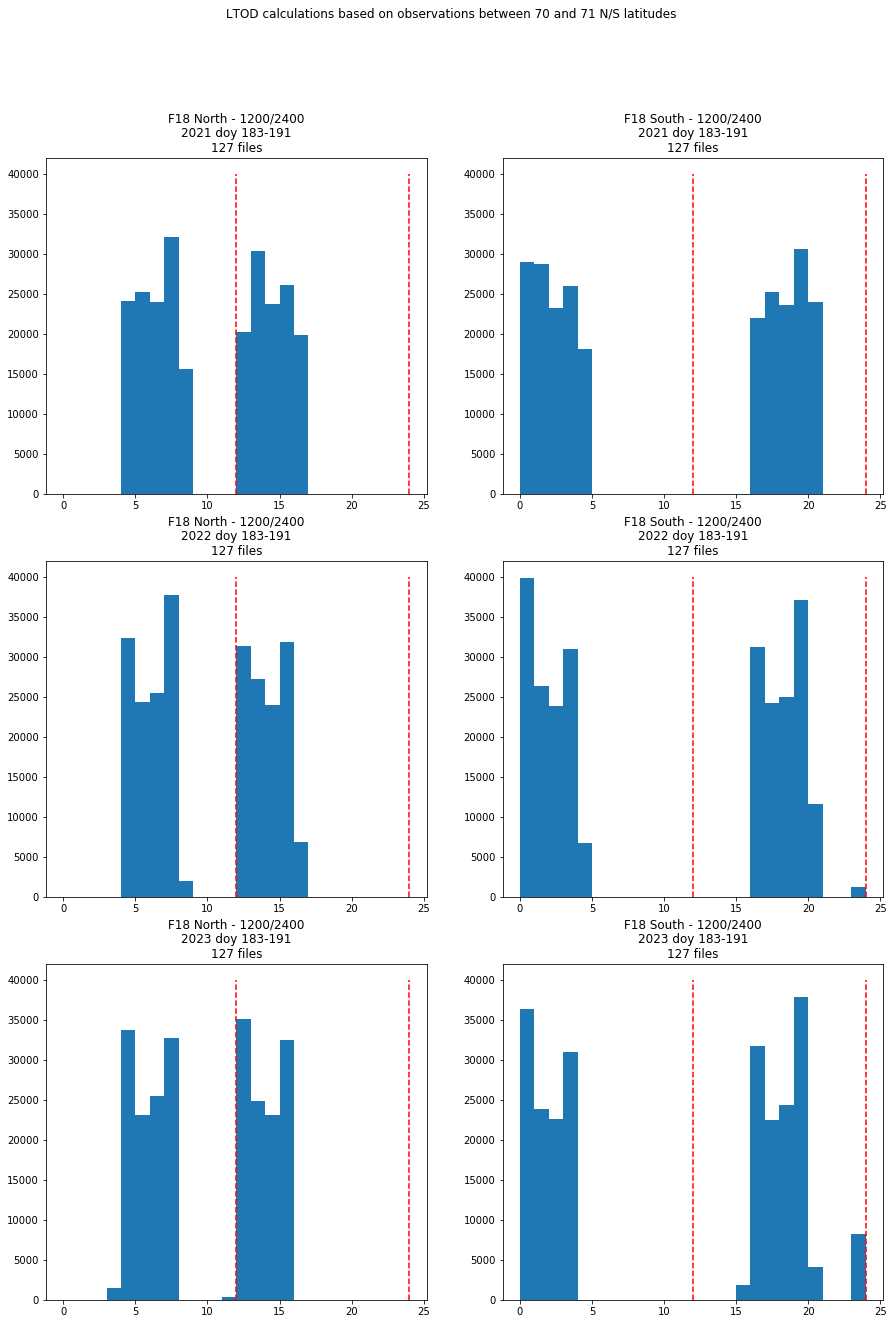

In [14]:
fig = plt.figure(figsize=(15,21))
plt.suptitle('LTOD calculations based on observations between 70 and 71 N/S latitudes')
a = fig.add_subplot(3,2,1)
plt.hist(ftn_F18_2021,bins=(np.arange(25)))
plt.plot([24, 24], [0, 40000], color='r', linestyle='--')
plt.plot([12, 12], [0, 40000], color='r', linestyle='--')
a.set_title('F18 North - 1200/2400\n2021 doy 183-191\n127 files')
a = fig.add_subplot(3,2,2)
plt.hist(fts_F18_2021,bins=(np.arange(25)))
plt.plot([24, 24], [0, 40000], color='r', linestyle='--')
plt.plot([12, 12], [0, 40000], color='r', linestyle='--')
a.set_title('F18 South - 1200/2400\n2021 doy 183-191\n127 files')
a = fig.add_subplot(3,2,3)
plt.hist(ftn_F18_2022,bins=(np.arange(25)))
plt.plot([24, 24], [0, 40000], color='r', linestyle='--')
plt.plot([12, 12], [0, 40000], color='r', linestyle='--')
a.set_title('F18 North - 1200/2400\n2022 doy 183-191\n127 files')
a = fig.add_subplot(3,2,4)
plt.hist(fts_F18_2022,bins=(np.arange(25)))
plt.plot([24, 24], [0, 40000], color='r', linestyle='--')
plt.plot([12, 12], [0, 40000], color='r', linestyle='--')
a.set_title('F18 South - 1200/2400\n2022 doy 183-191\n127 files')
a = fig.add_subplot(3,2,5)
plt.hist(ftn_F18_2023,bins=(np.arange(25)))
plt.plot([24, 24], [0, 40000], color='r', linestyle='--')
plt.plot([12, 12], [0, 40000], color='r', linestyle='--')
a.set_title('F18 North - 1200/2400\n2023 doy 183-191\n127 files')
a = fig.add_subplot(3,2,6)
plt.hist(fts_F18_2023,bins=(np.arange(25)))
plt.plot([24, 24], [0, 40000], color='r', linestyle='--')
plt.plot([12, 12], [0, 40000], color='r', linestyle='--')
a.set_title('F18 South - 1200/2400\n2023 doy 183-191\n127 files')

plt.show()

In [15]:
fig.savefig('/projects/moha2290/LTOD/F18-2021-2023.png')

In [9]:
F16_2024 = sort(glob.glob('/scratch/alpine/moha2290/v2_0630_test/F16_GSX/*20240*.nc'))
F17_2024 = sort(glob.glob('/scratch/alpine/moha2290/v2_0630_test/F17_GSX/*20240*.nc'))
F18_2024 = sort(glob.glob('/scratch/alpine/moha2290/v2_0630_test/F18_GSX/*20240*.nc'))
print(len(F16_2024), len(F17_2024), len(F18_2024))

103 101 97


In [7]:
ftn_F16_2024 = create_ltod(F16_2024, lat_min = 70.0, lat_max = 71.0)
fts_F16_2024 = create_ltod(F16_2024, lat_max = -70.0, lat_min = -71.0)
ftn_F17_2024 = create_ltod(F17_2024, lat_min = 70.0, lat_max = 71.0)
fts_F17_2024 = create_ltod(F17_2024, lat_max = -70.0, lat_min = -71.0)
ftn_F18_2024 = create_ltod(F18_2024, lat_min = 70.0, lat_max = 71.0)
fts_F18_2024 = create_ltod(F18_2024, lat_max = -70.0, lat_min = -71.0)

/tmp/ipykernel_1723620/2390887965.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lat = np.array(fid.variables['latitude_loc1'])
/tmp/ipykernel_1723620/2390887965.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = np.array(fid.variables['longitude_loc1'])
/tmp/ipykernel_1723620/2390887965.py:10: DeprecationWarning: `np.bool` is a depreca

<function matplotlib.pyplot.show(*args, **kw)>

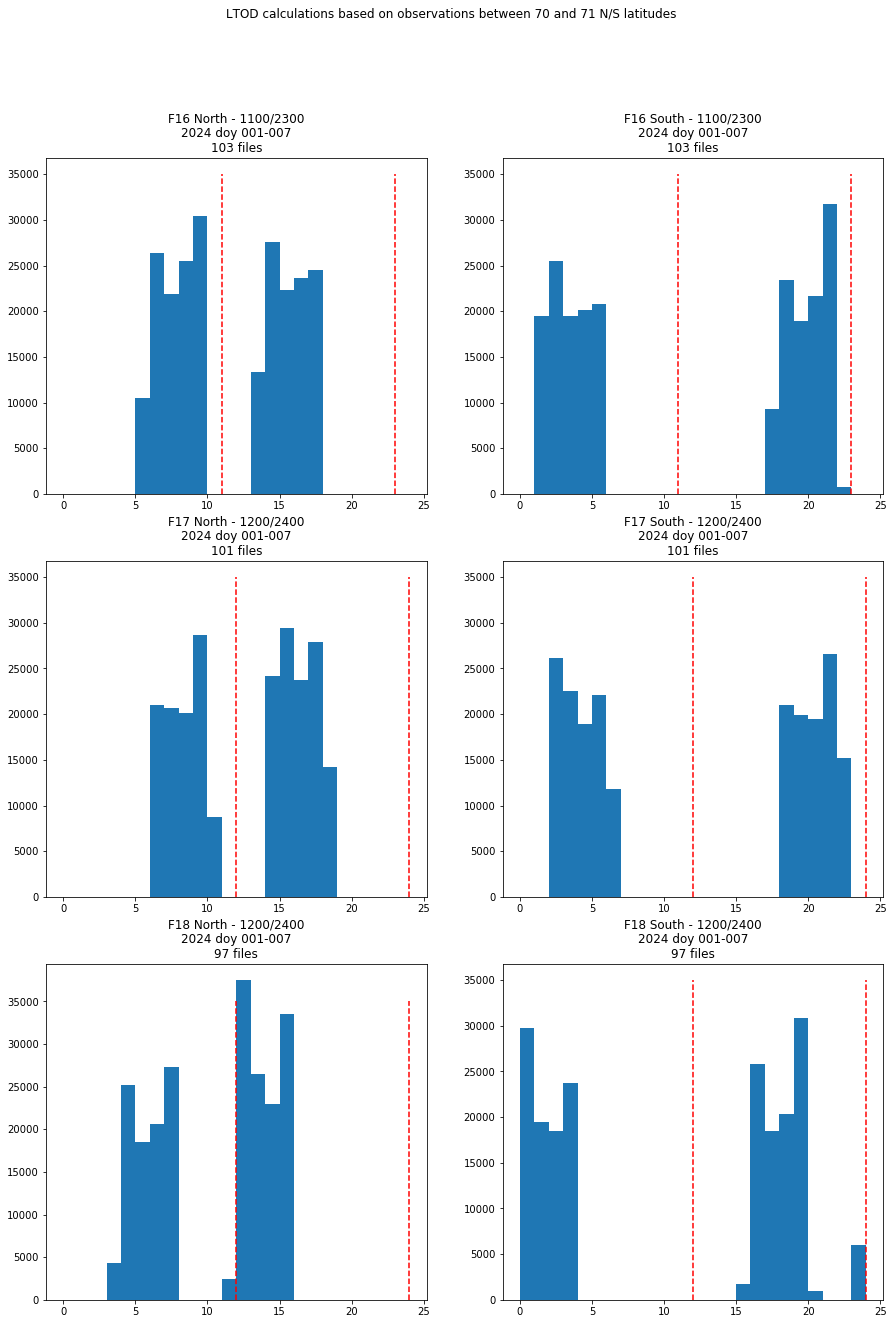

In [11]:
fig = plt.figure(figsize=(15,21))
plt.suptitle('LTOD calculations based on observations between 70 and 71 N/S latitudes')
a = fig.add_subplot(3,2,1)
plt.hist(ftn_F16_2024,bins=(np.arange(25)))
plt.plot([23, 23], [0, 35000], color='r', linestyle='--')
plt.plot([11, 11], [0, 35000], color='r', linestyle='--')
a.set_title('F16 North - 1100/2300\n2024 doy 001-007\n103 files')
a = fig.add_subplot(3,2,2)
plt.hist(fts_F16_2024,bins=(np.arange(25)))
plt.plot([23, 23], [0, 35000], color='r', linestyle='--')
plt.plot([11, 11], [0, 35000], color='r', linestyle='--')
a.set_title('F16 South - 1100/2300\n2024 doy 001-007\n103 files')
a = fig.add_subplot(3,2,3)
plt.hist(ftn_F17_2024,bins=(np.arange(25)))
plt.plot([24, 24], [0, 35000], color='r', linestyle='--')
plt.plot([12, 12], [0, 35000], color='r', linestyle='--')
a.set_title('F17 North - 1200/2400\n2024 doy 001-007\n101 files')
a = fig.add_subplot(3,2,4)
plt.hist(fts_F17_2024,bins=(np.arange(25)))
plt.plot([24, 24], [0, 35000], color='r', linestyle='--')
plt.plot([12, 12], [0, 35000], color='r', linestyle='--')
a.set_title('F17 South - 1200/2400\n2024 doy 001-007\n101 files')
a = fig.add_subplot(3,2,5)
plt.hist(ftn_F18_2024,bins=(np.arange(25)))
plt.plot([24, 24], [0, 35000], color='r', linestyle='--')
plt.plot([12, 12], [0, 35000], color='r', linestyle='--')
a.set_title('F18 North - 1200/2400\n2024 doy 001-007\n97 files')
a = fig.add_subplot(3,2,6)
plt.hist(fts_F18_2024,bins=(np.arange(25)))
plt.plot([24, 24], [0, 35000], color='r', linestyle='--')
plt.plot([12, 12], [0, 35000], color='r', linestyle='--')
a.set_title('F18 South - 1200/2400\n2024 doy 001-007\n97 files')
plt.show

In [12]:
fig.savefig('/projects/moha2290/LTOD/F16-F17-F18-2024.png')

140


/tmp/ipykernel_1743100/2390887965.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lat = np.array(fid.variables['latitude_loc1'])
/tmp/ipykernel_1743100/2390887965.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = np.array(fid.variables['longitude_loc1'])
/tmp/ipykernel_1743100/2390887965.py:10: DeprecationWarning: `np.bool` is a depreca

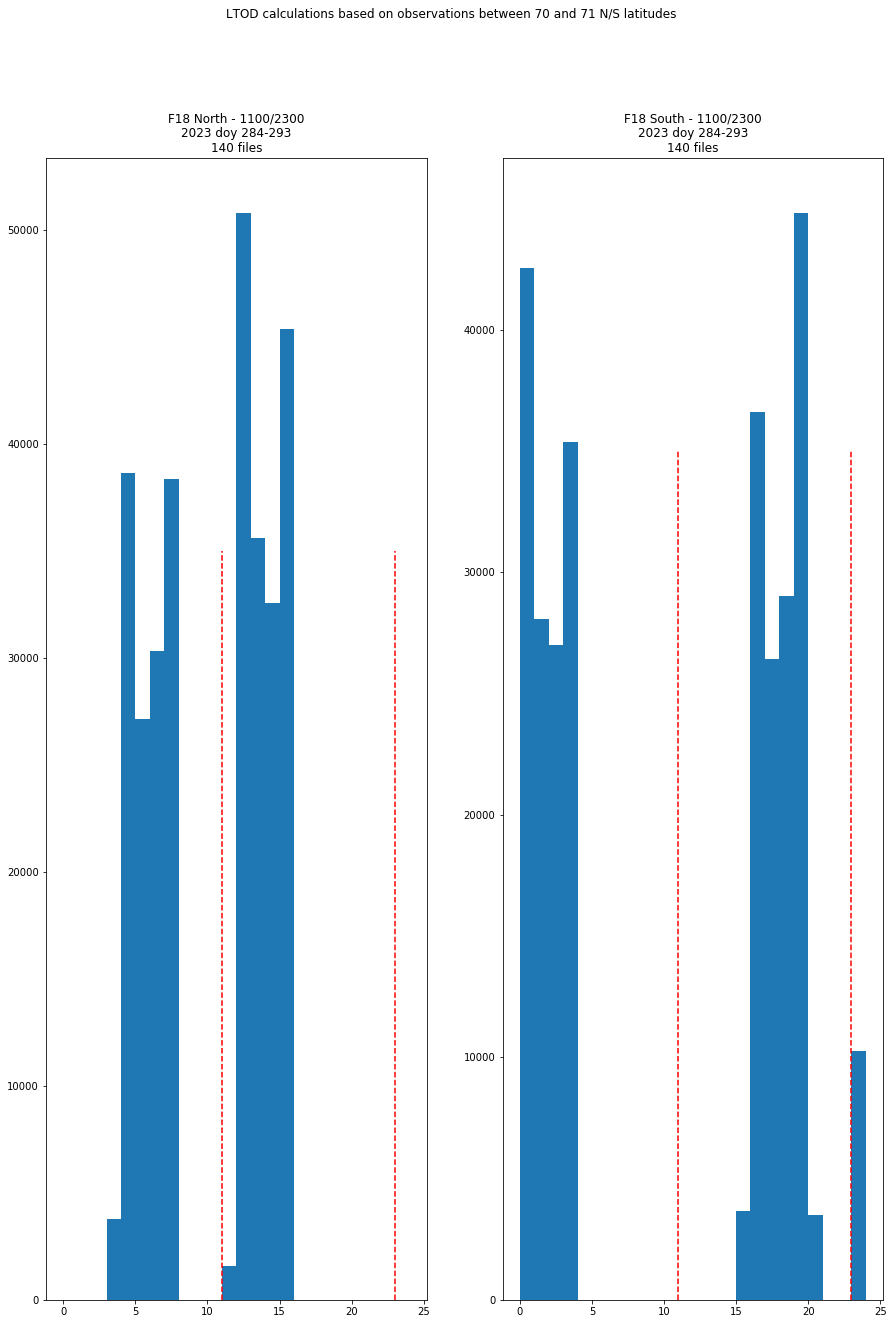

In [4]:
F18_2023 = sort(glob.glob('/scratch/alpine/moha2290/v2_0630_test/F18_GSX/*2023101*.nc'))
print(len(F18_2023))
ftn_F18_2023 = create_ltod(F18_2023, lat_min = 70.0, lat_max = 71.0)
fts_F18_2023 = create_ltod(F18_2023, lat_max = -70.0, lat_min = -71.0)
fig = plt.figure(figsize=(15,21))
plt.suptitle('LTOD calculations based on observations between 70 and 71 N/S latitudes')
a = fig.add_subplot(1,2,1)
plt.hist(ftn_F18_2023,bins=(np.arange(25)))
plt.plot([23, 23], [0, 35000], color='r', linestyle='--')
plt.plot([11, 11], [0, 35000], color='r', linestyle='--')
a.set_title('F18 North - 1100/2300\n2023 doy 284-293\n140 files')
a = fig.add_subplot(1,2,2)
plt.hist(fts_F18_2023,bins=(np.arange(25)))
plt.plot([23, 23], [0, 35000], color='r', linestyle='--')
plt.plot([11, 11], [0, 35000], color='r', linestyle='--')
a.set_title('F18 South - 1100/2300\n2023 doy 284-293\n140 files')
plt.show()

In [5]:
np.shape(ftn_F18_2023)

(41632380,)

In [9]:
ftn_F18_2023[0:100]

masked_array(data=[--, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --],
             mask=[ True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  Tru

In [6]:
fig.savefig('/projects/moha2290/LTOD/F18-2023.png')

In [4]:
A2_2024 = sort(glob.glob('/scratch/alpine/moha2290/v2_0630_test/AMSR2_GSX/*20240*.nc'))
print(len(A2_2024))

114


In [ ]:
ftn_A2_2024 = create_ltod(A2_2024, lat_min = 70.0, lat_max = 71.0)
fts_A2_2024 = create_ltod(A2_2024, lat_max = -70.0, lat_min = -71.0)


/tmp/ipykernel_1742942/2390887965.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lat = np.array(fid.variables['latitude_loc1'])
/tmp/ipykernel_1742942/2390887965.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lon = np.array(fid.variables['longitude_loc1'])
/tmp/ipykernel_1742942/2390887965.py:10: DeprecationWarning: `np.bool` is a depreca

In [4]:
F16_2018 = sort(glob.glob("/projects/PMESDR/vagrant/F16_GSX/*D2018070*.nc"))
print(len(F16_2018))
F16_2019 = sort(glob.glob("/projects/PMESDR/vagrant/F16_GSX/*FCDR*D2019070*.nc"))
print(len(F16_2019))
F16_2020 = sort(glob.glob("/projects/PMESDR/vagrant/F16_GSX/*D2020070*.nc"))
print(len(F16_2020))
F16_2021 = sort(glob.glob("/projects/PMESDR/vagrant/F16_GSX/*D2021070*.nc"))
print(len(F16_2021))
F16_2022 = sort(glob.glob("/projects/PMESDR/vagrant/F16_GSX/*D2022070*.nc"))
print(len(F16_2022))
F16_2023 = sort(glob.glob("/projects/PMESDR/vagrant/F16_GSX/*2023051*.nc"))
print(len(F16_2023))

127
126
126
126
126
96


In [ ]:
ftn_F16_2018 = create_ltod(F16_2018, lat_min = 70.0, lat_max = 71.0)
fts_F16_2018 = create_ltod(F16_2018, lat_max = -70.0, lat_min = -71.0)

In [ ]:
ftn_F16_2019 = create_ltod(F16_2019, lat_min = 70.0, lat_max = 71.0)
fts_F16_2019 = create_ltod(F16_2019, lat_max = -70.0, lat_min = -71.0)
ftn_F16_2020 = create_ltod(F16_2020, lat_min = 70.0, lat_max = 71.0)
fts_F16_2020 = create_ltod(F16_2020, lat_max = -70.0, lat_min = -71.0)

In [ ]:
ftn_F16_2023 = create_ltod(F16_2023, lat_min = 70.0, lat_max = 71.0)

In [5]:
ftn_F16_2023 = create_ltod(F16_2023, lat_min = 70.0, lat_max = 71.0)
fts_F16_2023 = create_ltod(F16_2023, lat_max = -70.0, lat_min = -71.0)

In [6]:
ftn_F16_2021 = create_ltod(F16_2021, lat_min = 70.0, lat_max = 71.0)
fts_F16_2021 = create_ltod(F16_2021, lat_max = -70.0, lat_min = -71.0)
ftn_F16_2022 = create_ltod(F16_2022, lat_min = 70.0, lat_max = 71.0)
fts_F16_2022 = create_ltod(F16_2022, lat_max = -70.0, lat_min = -71.0)


In [ ]:
fig = plt.figure(figsize=(15,21))
plt.suptitle('LTOD calculations based on observations between 70 and 71 N/S latitudes')
a = fig.add_subplot(3,2,1)
plt.hist(ftn_F16_2018,bins=(np.arange(25)))
plt.plot([22, 22], [0, 35000], color='r', linestyle='--')
plt.plot([10, 10], [0, 35000], color='r', linestyle='--')
a.set_title('F16 North - 1000/2200\n2018 doy 182-190\n127 files')
a = fig.add_subplot(3,2,2)
plt.hist(fts_F16_2018,bins=(np.arange(25)))
plt.plot([22, 22], [0, 35000], color='r', linestyle='--')
plt.plot([10, 10], [0, 35000], color='r', linestyle='--')
a.set_title('F16 South - 1000/2200\n2018 doy 182-190\n127 files')
a = fig.add_subplot(3,2,3)
plt.hist(ftn_F16_2019,bins=(np.arange(25)))
plt.plot([22, 22], [0, 35000], color='r', linestyle='--')
plt.plot([10, 10], [0, 35000], color='r', linestyle='--')
a.set_title('F16 North - 1000/2200\n2019 doy 182-190\n126 files')
a = fig.add_subplot(3,2,4)
plt.hist(fts_F16_2019,bins=(np.arange(25)))
plt.plot([22, 22], [0, 35000], color='r', linestyle='--')
plt.plot([10, 10], [0, 35000], color='r', linestyle='--')
a.set_title('F16 South - 1000/2200\n2019 doy 182-190\n126 files')
a = fig.add_subplot(3,2,5)
plt.hist(ftn_F16_2020,bins=(np.arange(25)))
plt.plot([22, 22], [0, 35000], color='r', linestyle='--')
plt.plot([10, 10], [0, 35000], color='r', linestyle='--')
a.set_title('F16 North - 1000/2200\n2020 doy 182-190\n126 files')
a = fig.add_subplot(3,2,6)
plt.hist(fts_F16_2020,bins=(np.arange(25)))
plt.plot([23, 23], [0, 35000], color='r', linestyle='--')
plt.plot([11, 11], [0, 35000], color='r', linestyle='--')
a.set_title('F16 South - 1000/2200\n2020 doy 182-190\n126 files')
plt.show

In [ ]:
fig.savefig('/projects/PMESDR/vagrant/LTOD/F16-2018-2020.png')

<function matplotlib.pyplot.show>

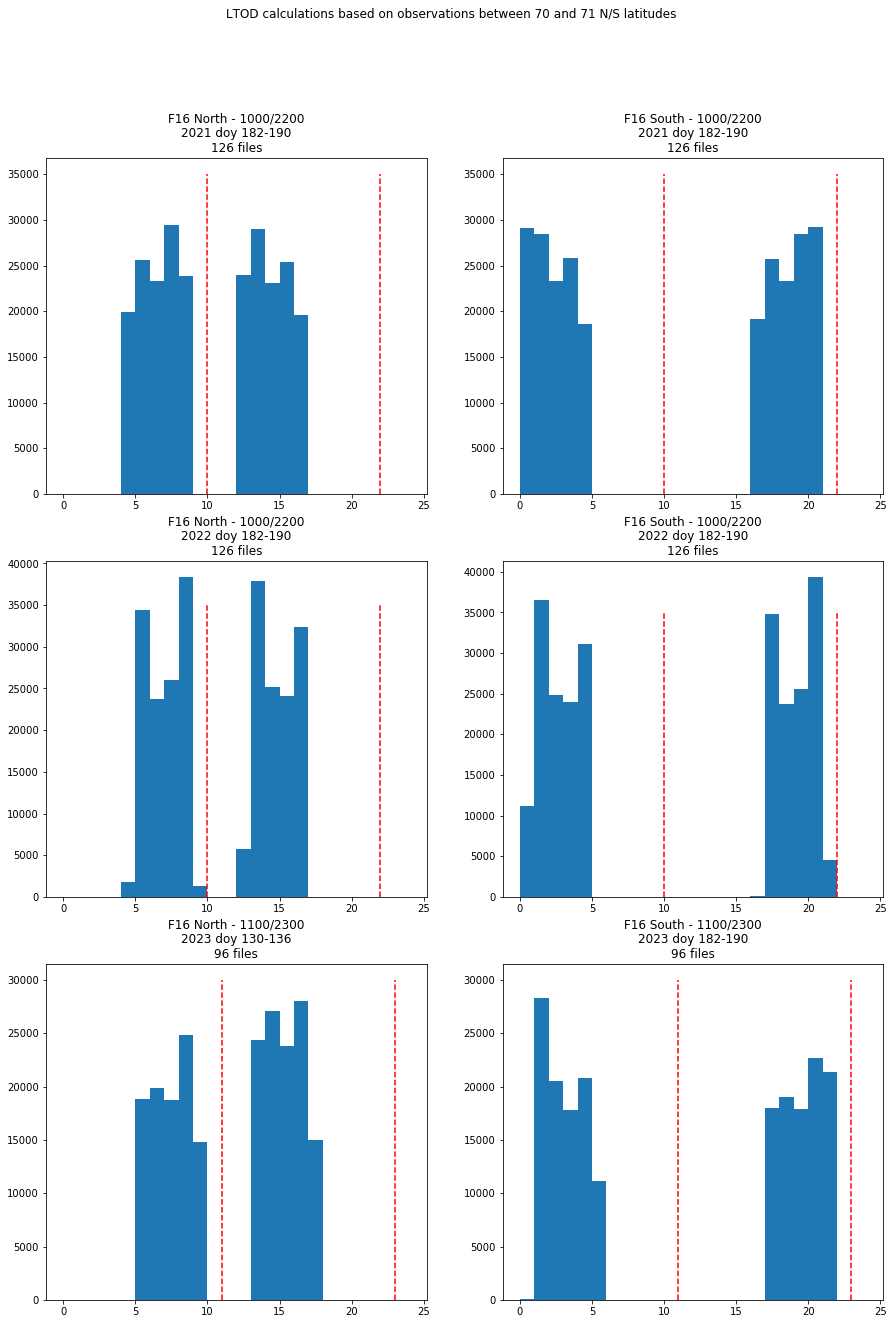

In [9]:
fig = plt.figure(figsize=(15,21))
plt.suptitle('LTOD calculations based on observations between 70 and 71 N/S latitudes')
a = fig.add_subplot(3,2,1)
plt.hist(ftn_F16_2021,bins=(np.arange(25)))
plt.plot([22, 22], [0, 35000], color='r', linestyle='--')
plt.plot([10, 10], [0, 35000], color='r', linestyle='--')
a.set_title('F16 North - 1000/2200\n2021 doy 182-190\n126 files')
a = fig.add_subplot(3,2,2)
plt.hist(fts_F16_2021,bins=(np.arange(25)))
plt.plot([22, 22], [0, 35000], color='r', linestyle='--')
plt.plot([10, 10], [0, 35000], color='r', linestyle='--')
a.set_title('F16 South - 1000/2200\n2021 doy 182-190\n126 files')
a = fig.add_subplot(3,2,3)
plt.hist(ftn_F16_2022,bins=(np.arange(25)))
plt.plot([22, 22], [0, 35000], color='r', linestyle='--')
plt.plot([10, 10], [0, 35000], color='r', linestyle='--')
a.set_title('F16 North - 1000/2200\n2022 doy 182-190\n126 files')
a = fig.add_subplot(3,2,4)
plt.hist(fts_F16_2022,bins=(np.arange(25)))
plt.plot([22, 22], [0, 35000], color='r', linestyle='--')
plt.plot([10, 10], [0, 35000], color='r', linestyle='--')
a.set_title('F16 South - 1000/2200\n2022 doy 182-190\n126 files')
a = fig.add_subplot(3,2,5)
plt.hist(ftn_F16_2023,bins=(np.arange(25)))
plt.plot([23, 23], [0, 30000], color='r', linestyle='--')
plt.plot([11, 11], [0, 30000], color='r', linestyle='--')
a.set_title('F16 North - 1100/2300\n2023 doy 130-136\n96 files')
a = fig.add_subplot(3,2,6)
plt.hist(fts_F16_2023,bins=(np.arange(25)))
plt.plot([23, 23], [0, 30000], color='r', linestyle='--')
plt.plot([11, 11], [0, 30000], color='r', linestyle='--')
a.set_title('F16 South - 1100/2300\n2023 doy 182-190\n96 files')
plt.show

In [10]:
fig.savefig('/projects/PMESDR/vagrant/LTOD/F16-2021-2023.png')

In [ ]:
ftn_F16_2023 = fts_F16_2023 = 0
ftn_F16_2022 = fts_F16_2022 = 0
ftn_F16_2021 = fts_F16_2021 = 0

In [ ]:
ftn_F16_2020 = create_ltod(F16_2020, lat_min = 70.0, lat_max = 71.0)
fts_F16_2020 = create_ltod(F16_2020, lat_max = -70.0, lat_min = -71.0)


In [ ]:
ftn_F16_2019 = create_ltod(F16_2019, lat_min = 70.0, lat_max = 71.0)
fts_F16_2019 = create_ltod(F16_2019, lat_max = -70.0, lat_min = -71.0)
ftn_F16_2020 = create_ltod(F16_2020, lat_min = 70.0, lat_max = 71.0)
fts_F16_2020 = create_ltod(F16_2020, lat_max = -70.0, lat_min = -71.0)
ftn_F16_2021 = create_ltod(F16_2021, lat_min = 70.0, lat_max = 71.0)
fts_F16_2021 = create_ltod(F16_2021, lat_max = -70.0, lat_min = -71.0)
ftn_F16_2022 = create_ltod(F16_2022, lat_min = 70.0, lat_max = 71.0)
fts_F16_2022 = create_ltod(F16_2022, lat_max = -70.0, lat_min = -71.0)
ftn_F16_2023 = create_ltod(F16_2023, lat_min = 70.0, lat_max = 71.0)
fts_F16_2023 = create_ltod(F16_2023, lat_max = -70.0, lat_min = -71.0)

In [ ]:
print(len(F16_2017))

In [ ]:
%cd /scratch/summit/moha2290/AMSR2_GSX

In [ ]:
#A2_2012 = sort(glob.glob("/projects/PMESDR/vagrant/AMSR2_GSX/*V.2012070[234]*.nc"))
#print (len(A2_2012))
A2_2016 = sort(glob.glob("/projects/PMESDR/vagrant/AMSR2_GSX/*V.2016070[234]*.nc"))
print(len(A2_2016))
#A2_2021 = sort(glob.glob("/scratch/summit/moha2290/AMSR2_GSX/*V.2021070[456]*.nc"))
#print (len(A2_2012), len(A2_2016), len(A2_2021))

In [ ]:
%cd /projects/PMESDR/vagrant

In [ ]:
ftn_A2_2016 = create_ltod(A2_2016, lat_min = 70.0, lat_max = 71.0)
fts_A2_2016 = create_ltod(A2_2016, lat_max = -70.0, lat_min = -71.0)

In [ ]:
fig = plt.figure(figsize=(15,12))
plt.suptitle('LTOD calculations based on observations between 70 and 71 N/S latitudes')
a = fig.add_subplot(1,2,1)
plt.hist(ftn_A2_2016, bins=(np.arange(25)))
a.set_title('AMSR2 North - July 2016')
plt.plot([8, 8], [0, 35000], color='r', linestyle='--')
plt.plot([20, 20], [0, 35000], color='r', linestyle='--')
a = fig.add_subplot(1, 2, 2)
plt.hist(fts_A2_2012, bins=(np.arange(25)))
a.set_title('AMSR2 South - July 2016')
plt.plot([8, 8], [0, 35000], color='r', linestyle='--')
plt.plot([20, 20], [0, 35000], color='r', linestyle='--')
plt.show
fig.savefig('/projects/PMESDR/vagrant/LTOD/AMSR2_2016_ltod.png')